I'm analysing data from the 2014 tennis season, focussing on the four Grand Slam tournaments: the Australian Open, the French Open, Wimbledon, and the US Open. These four tournaments represent the pinnacles of achievement for a player. However, what I'm more interested in is whether we can use data from one tournament to predict results from others. That is, how likely is that the pattern of results seen in one tournament will be replicated in another? Does one particular predictive method outperform others? And, how much data do we need to make good predictions?

In [136]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score, roc_auc_score
import os, random, time
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from IPython.display import HTML

First, let's load in the data which I obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Tennis+Major+Tournament+Match+Statistics)

In [106]:
#Australian Open
fname_aus_2014 = os.getcwd() + '/Tennis-Major-Tournaments-Match-Statistics/AusOpen-men-2014.csv'
aus_2014 = pd.read_csv(fname_aus_2014)
aus_2014.drop(labels=['Player1', 'Player2'], axis=1, inplace=True)
aus_2014.fillna(0, inplace=True)

#French Open
fname_french_2014 = os.getcwd() + '/Tennis-Major-Tournaments-Match-Statistics/FrenchOpen-men-2014.csv'
fre_2014 = pd.read_csv(fname_french_2014)
fre_2014.drop(labels=['Player1', 'Player2'], axis=1, inplace=True)
fre_2014.fillna(0, inplace=True)

#Wimbledon
fname_wimbledon_2014 = os.getcwd() + '/Tennis-Major-Tournaments-Match-Statistics/Wimbledon-men-2014.csv'
wimbledon_2014 = pd.read_csv(fname_wimbledon_2014)
wimbledon_2014.drop(labels=['Player1', 'Player2'], axis=1, inplace=True)
wimbledon_2014.fillna(0, inplace=True)

#US Open
fname_us_2014 = os.getcwd() + '/Tennis-Major-Tournaments-Match-Statistics/USOpen-men-2014.csv'
us_2014 = pd.read_csv(fname_us_2014)
us_2014.drop(labels=['Player1', 'Player2'], axis=1, inplace=True)
us_2014.fillna(0, inplace=True)

Let's look at a sample of the data - it's consistent across the various dataframes, so I'm just going to show one here. Each row of the data represents a single match between 2 players, and various statistics about the way they played in that match. Some pieces of information contained in this data are - 'FSW.1' & 'FSW.2', the percentage of first serves that each player (1 and 2) managed to win, 'SSW.1' & 'SSW.2', the percentage of second serves that they won, etc. It also includes information about how many aces they score, how many double faults they committed, net points they won, etc. It also includes the score in each set of the match.

I'm also going to clean up the data a bit, remove unnecesary columns, and fill in NA values - classifiers are often unable to work with these.Of course, it's important to point out which columns of the data contain NAs: In tennis, the men's game in a Grand Slam is a best of 5 set match, meaning that it can be 3, 4, or 5 sets long. In matches that ended in either 3 or 4 sets, the 'unplayed' sets contain NA values, indicating that they did take place.

In [105]:
aus_2014.head()

,Player1,Player2,Round,Result,FNL1,FNL2,FSP.1,FSW.1,SSP.1,SSW.1,...,BPC.2,BPW.2,NPA.2,NPW.2,TPW.2,ST1.2,ST2.2,ST3.2,ST4.2,ST5.2
0,Lukas Lacko,Novak Djokovic,1,0,0,3,61,35,39,18,...,4,8,8,9,101,6,7,6,0,0
1,Leonardo Mayer,Albert Montanes,1,1,3,0,61,31,39,13,...,0,0,0,0,42,1,3,1,0,0
2,Marcos Baghdatis,Denis Istomin,1,0,0,3,52,53,48,20,...,4,13,12,16,126,6,7,6,0,0
3,Dmitry Tursunov,Michael Russell,1,1,3,0,53,39,47,24,...,1,7,0,0,79,2,2,3,0,0
4,Juan Monaco,Ernests Gulbis,1,0,1,3,76,63,24,12,...,3,5,16,28,127,1,6,7,6,0


##Predictions - 1

Now, let's get started with some prediction tasks. The Australian Open is the first Grand Slam of the year, and is played on a 'hard court' surface, similar to the US Open (which is the last one of the year). The French Open is played on a clay court, and Wimbledon is played on grass. Grass is the fastest surface to play on, while clay is the slowest. The 2 hard court surfaces fall somewhere in between.

Let's use the Australian Open to predict results from the other tournaments: one might expect it to work best for the US Open since both are played on a hard court. Additionally, the weather during the two tournaments is likely to be similar (temperatures are in the 15 - 25 C range).

**Prediction: Australian Open will predict results for the US Open better than for the French Open or Wimbledon**

However, what kind of model do we use? We're trying to predict a binary variable: for each match, does Player1 win or Player2? Our target column is the 'Result' column of each dataframe. There are several classifiers that could be used. I've selected 3: *Logistic Regression, Random Forests, and Naive Bayes*, since these have all been used for binary classification.

Logistic Regression is a classifier that works well with larger sets than smaller ones. Naive Bayes is considered better for smaller data sets. Random Forests is a method that combines various classifiers, and is expected to have a lower classification error.

**Prediction: Naive Bayes and Random Forests will work better than Logistic Regression**

###Metrics - Area Under the Curve

The way I've measured the classifier performance is using a metric called 'Area Under the Curve' or 'AUC'. AUC is typically calculated for a binary classifier by examining the ratio of correct predictions (aka True Positives) to incorrect predictions (False Poasitives). It's  measure that is commonly used, and widely accepted.

The AUC ranges from 0.5 to 1, with 0.5 representing 'chance' performance - meaning that the classifier gets as many incorrect as it does correct. 1 represents perfect classification - there were no instances that the classifier predicted as being part of the positive class that were actually part of the negative class. Higher scores are better.

To use the graphical interpretation of AUC, we need to plot a Receiver Operating Characteristic curve that shows how many True Positives and False Positives there are at various threshold levels in the data. A simple rule-of-thumb is that the closer the graph is to the point (0, 1) in the graph, the better the classifier is at separating True Positives from False Positives.

###Figures

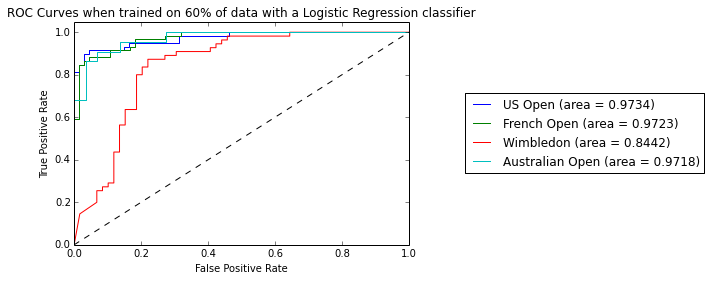

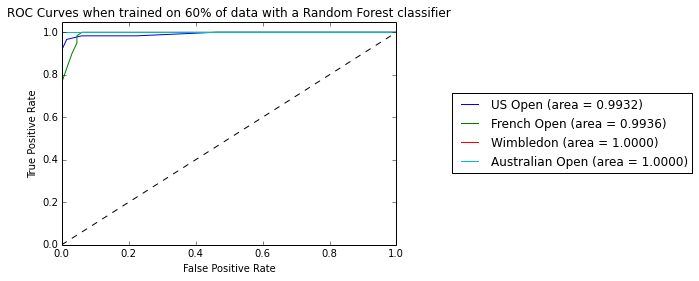

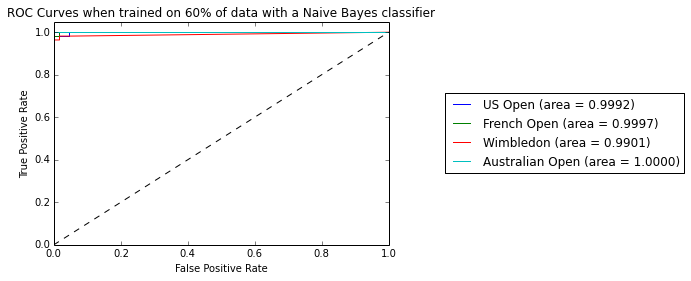

In [149]:
tournaments = ['Australian Open', 'French Open', 'Wimbledon', 'US Open']
model_names = ['Logistic Regression', 'Random Forest', 'Naive Bayes']
tournament_data = {'Australian Open': aus_2014, 
                   'French Open': fre_2014, 
                   'Wimbledon': wimbledon_2014, 
                   'US Open': us_2014}

for model_name in model_names:
    build_model(model_name, tournament_data, train_on=tournaments[0], test_set_size=0.4)

###Results

Each graph above represent the Receiver Operating Characteristic for a different type of classifier. The legend box on the right of the graph shows the AUC measure for each tournament. To provide some orientation, the first graph is for a Logistic Regression classifier trained on (80% of the) Australian Open data. The AUC is for the test datasets on which we evaluate the classifier: US Open, French Open, Wimbledon, and the remaining 20% of the Australian Open data. As mentioned earlier, higher AUCs are better

**Prediction 1:** Here, we find that when we train on Australian Open data, we can achieve excellent prediction results for all the other tournaments. From this, it appears that all three tournaments can be predicted using data from the Australian Open. Not only does it predict the results of the US Open well, but the other tournaments as well.

**Prediction 2:** Here, it does appear that we were accurate about Logistic Regression performing worse than the other two, Random Forests, and Naive Bayes.

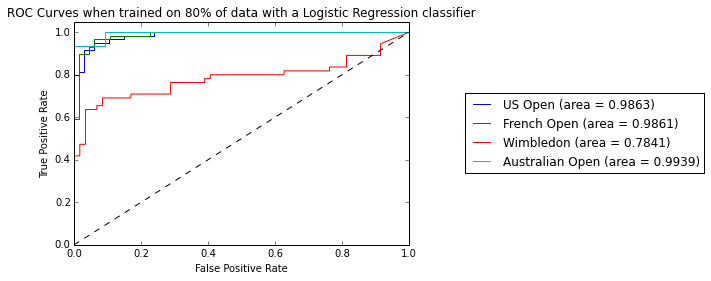

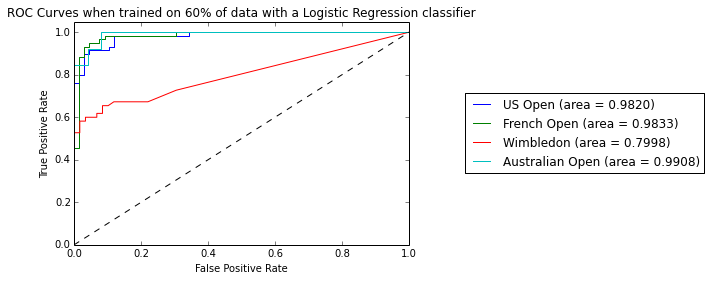

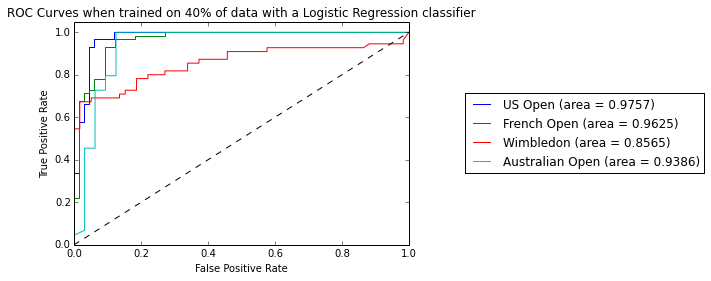

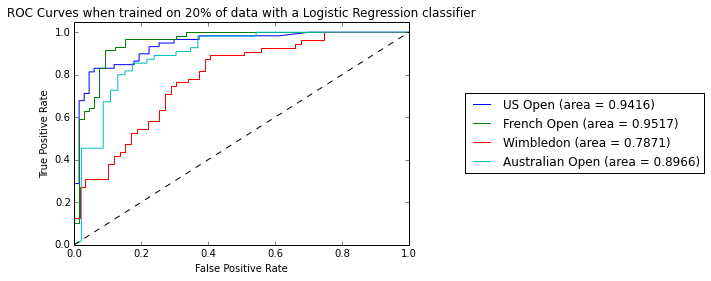

In [144]:
test_set_sizes = [0.2, 0.4, 0.6, 0.8]
for tss in test_set_sizes:
    build_model('Logistic Regression', tournament_data, train_on=tournaments[0], test_set_size=tss)

##Predictions - 2

Next, I'm going to look at how much data we need to make accurate predictions. Taking the Australian Open as our training set, how many rounds of matches from the Australian Open do we need to predict results from other tournaments? If we use too much data from one tournament, do we risk overfitting the data? That is, will our classifier be *so* finely-tuned to the parameters that determine outcomes at the Australian Open that it will be unable to predict the others?

We need to keep in mind that the initial rounds of any tournament will contain more examples than later rounds. 

**Prediction: Using too too much data from the Australian Open will result in less accurate predictions, because of overfitting.**

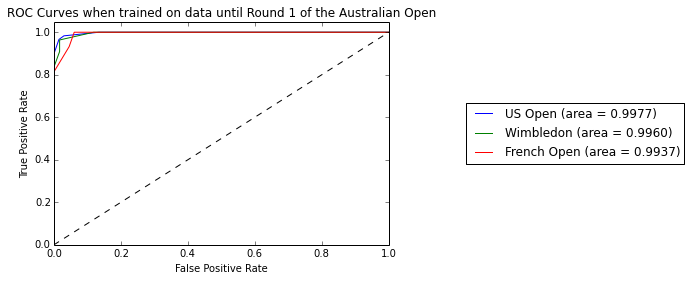

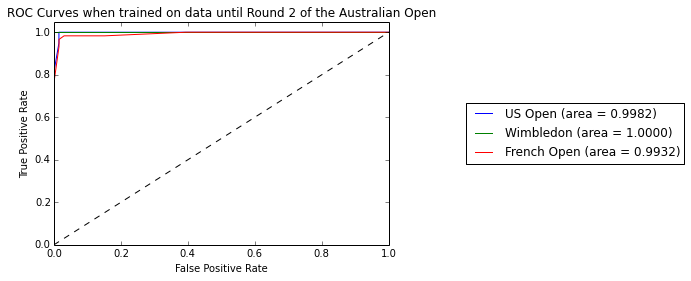

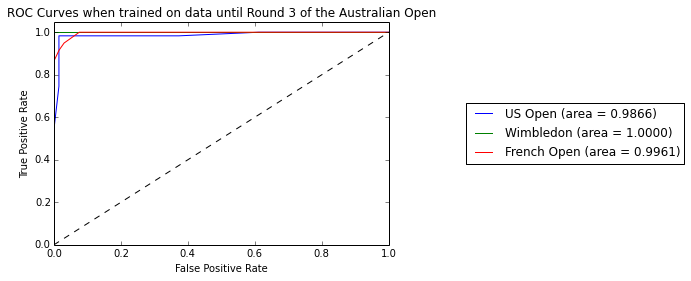

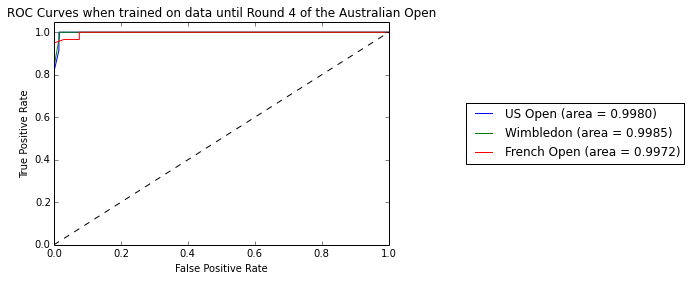

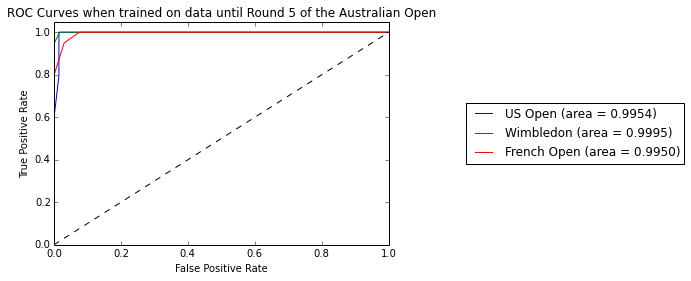

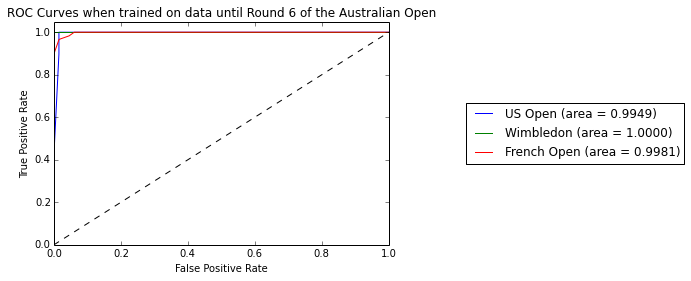

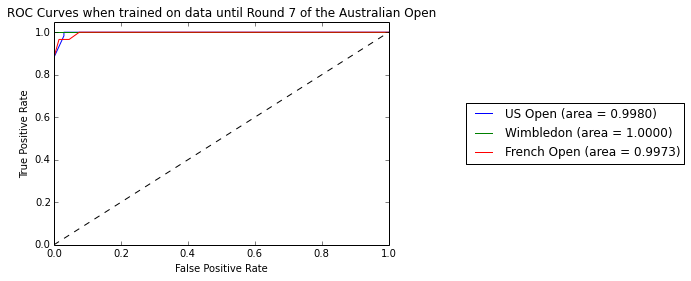

In [238]:
for N in xrange(1, tournament_data['Australian Open']['Round'].max()+1):
    build_model_rounds(tournament_data, 'Random Forest', train_on='Australian Open', max_rounds=N, metric='auc', threshold=None)

###Results

Surprisingly, this prediction did not turn out to be correct - AUC for later round was comparable to earlier rounds, if not better. This suggests that our Random Forest classifier did not overfit the data from the Australian Open.

The more interesting (and subtle) outcome of this data is that it appears to be enough to train our classifier on data from the initial rounds of a tournament, and use this to predict all rounds from other tournaments.

## Prediction 3

Let's now look at the French Open - compared to Wimbledon, the court is much slower, resulting in play that is likely to be different. Consequently, the strategies and parameters for winning are also likely to be different. The US and Australian Opens are likely to have more similar strategies, since those courts are closer in speed to France than to Wimbldeon

**Prediction: French Open predictions are likely to be worse for Wimbledon than for the US and Australian Opens**

###Results

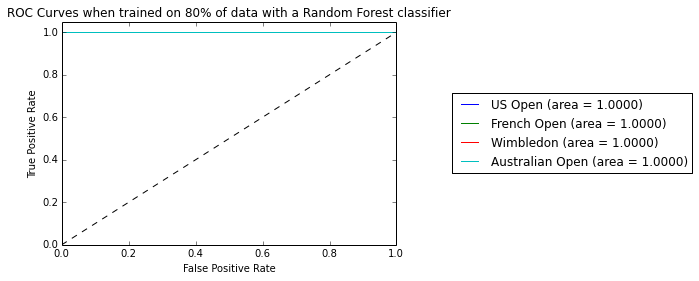

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [239]:
build_model('Random Forest', tournament_data, train_on='French Open', test_set_size=0.2)

Interestingly, the Random Forest algorithm does an excellent job of predicting results from Wimbledon as well s from other tournaments, based on the AUC. Given that in 2014, each tournament was won by a different player, this is surprising - illustrating the power of the Random Forest algorithm. 

Interestingly, when we use a Logistic Regression to predict results, the predictions appear to do substantially worse. This indicates that not only do the data matter, but also the specific choice of algorithm.

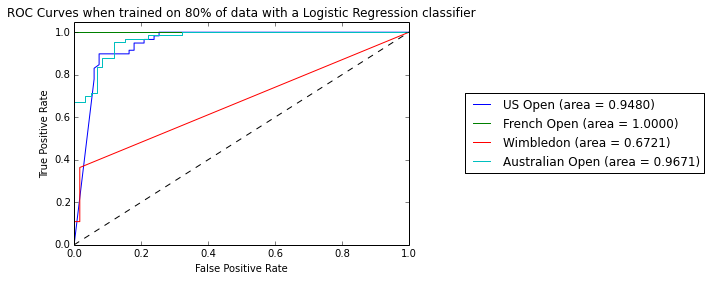

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [241]:
build_model('Logistic Regression', tournament_data, train_on='French Open', test_set_size=0.2)

In [146]:
def build_model(model_name, tournament_data, train_on, test_set_size):   
    models = {'Random Forest': RandomForestClassifier(), 
              'Logistic Regression': LogisticRegression(), 
              'Naive Bayes': GaussianNB()}
    tournaments = ['Australian Open', 'French Open', 'Wimbledon', 'US Open']
    
    X = tournament_data[train_on].drop(labels='Result', axis=1)
    y = tournament_data[train_on]['Result']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=int(time.time()))
    
    tennis_model = models[model_name].fit(X_train, y_train)
    
    x_validation = {train_on: X_test}
    y_validation = {train_on: y_test}
    
    other_tournaments = [t for t in tournaments if t != train_on]
    
    for other_tournament in other_tournaments:
        x_validation[other_tournament] = tournament_data[other_tournament].drop(labels='Result', axis=1)
        y_validation[other_tournament] = tournament_data[other_tournament]['Result']
        
    roc_auc = {}
    fpr = {}
    tpr = {}

    plt.figure()
    for i in x_validation.keys():
        disbursed = tennis_model.predict_proba(x_validation[i])
        fpr[i], tpr[i], _ = roc_curve(y_validation[i], disbursed[:, 1])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label='{0} (area = {1:0.4f})'''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves when trained on {0}% of data with a {1} classifier'''.format(int(100-test_set_size*100), model_name))
    plt.legend(loc="center right", bbox_to_anchor = (1.9, 0.5))
    plt.show()
    
    return plt

In [237]:
def build_model_rounds(tournament_data, model_name, train_on, max_rounds, metric, threshold):
    
    models = {'Random Forest': RandomForestClassifier(), 
              'Logistic Regression': LogisticRegression(), 
              'Naive Bayes': GaussianNB()}
    
    tournaments = tournament_data.keys()
    
    training = tournament_data[train_on]
    training_firstNrounds = training[training['Round'] <= max_rounds]
    X_train = training_firstNrounds.drop(labels=['Result', 'Round'], axis=1)
    y_train = training_firstNrounds['Result']
   
    tennis_model = models[model_name].fit(X_train, y_train)
    
    x_validation = {}
    y_validation = {}
    
    other_tournaments = [t for t in tournaments if t != train_on] 
    for other_tournament in other_tournaments:
        x_validation[other_tournament] = tournament_data[other_tournament].drop(labels=['Result', 'Round'], axis=1)
        y_validation[other_tournament] = tournament_data[other_tournament]['Result']
        
    roc_auc = {}
    fpr = {}
    tpr = {}
    score = {}

    plt.figure()
    val_keys = x_validation.keys()
    x_locs = range(1, len(val_keys)+1)
    
    for i in val_keys:
        disbursed = tennis_model.predict_proba(x_validation[i])
        if disbursed.shape[1] == 1:
            fpr[i], tpr[i], _ = roc_curve(y_validation[i], disbursed)
        else:
            fpr[i], tpr[i], _ = roc_curve(y_validation[i], disbursed[:, 1])
        roc_auc[i] = auc(fpr[i], tpr[i])
        score[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label='{0} (area = {1:0.4f})'''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="center right", bbox_to_anchor = (1.9, 0.5))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves when trained on data until Round {0} of the {1}'''.format(max_rounds, train_on))
    plt.show()